In [1]:
struct Delivery
    x::Float64
    y::Float64
end;
function random_delivery()
    x = rand(0.0:0.1:100.0)
    y = rand(0.0:0.1:100.0)
    return Delivery(x, y)
end;
random_delivery()

Delivery(82.1, 16.0)

In [2]:
struct TSProblem
    deliveries::Array{Delivery}
end;

function random_instance(n_deliveries)
    deliveries = [random_delivery() for _=1:n_deliveries]
    problem = TSProblem(deliveries)
    return problem
end;
random_instance(5)

TSProblem(Delivery[Delivery(50.9, 91.0), Delivery(51.7, 2.0), Delivery(69.3, 25.2), Delivery(6.3, 62.5), Delivery(9.0, 82.0)])

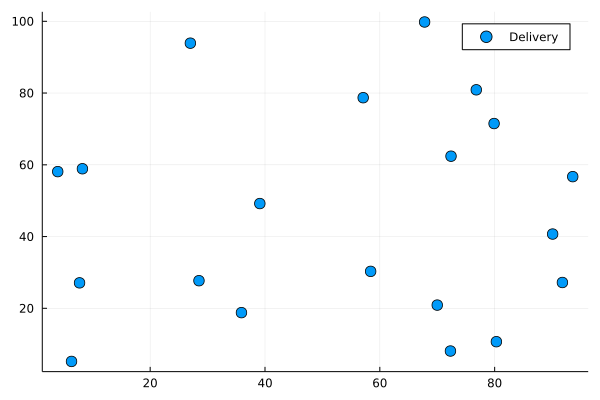

In [3]:
using Plots

function display_problem(problem)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    scatter(x_pos, y_pos, shape = :circle, markersize = 6, label= "Delivery")
end;

problem = random_instance(20)
display_problem(problem)

In [4]:
function dist(del1::Delivery, del2::Delivery)
    return sqrt((del1.x - del2.x)^2 + (del1.y - del2.y)^2)
end
function calc_travelmatrix(deliveries::Array{Delivery})
    tm = zeros(Float64, length(deliveries), length(deliveries))
    for i = 1:length(deliveries)
        for j = 1:length(deliveries)
            tm[i, j] = dist(deliveries[i], deliveries[j])
        end
    end
    return tm
end
travelmatrix = calc_travelmatrix(problem.deliveries)

20×20 Matrix{Float64}:
  0.0       89.7109   76.3823   …  36.3077  93.1731  75.8489  84.7264
 89.7109     0.0      29.4598      55.0136  29.5549  42.8789  53.0627
 76.3823    29.4598    0.0         49.2563  55.7556  60.3841  72.9389
 52.9544   101.358   103.444       54.8802  88.285   65.6062  66.0637
 76.3027    50.232    20.9335      58.1726  76.4641  78.9307  91.8103
 57.0491    42.6175   19.8225   …  34.5579  62.0994  59.222   72.2177
 89.9095    47.8841   70.2872      56.3887  20.1122  14.4959   8.4119
 61.1808    44.0      53.8416      27.013   33.5436  14.9305  26.1926
 87.9386    16.3783   42.343       51.7035  13.6066  28.2144  37.143
 50.6803    69.034    74.3587      30.568   56.5276  34.1646  37.9401
 39.1065    71.2672   71.8549   …  23.971   63.302   42.0534  47.9854
 31.232     90.8569   87.5743      38.3975  84.1001  62.6077  67.3362
 77.1723    20.1675    9.89798     46.4966  45.8705  51.5594  63.8539
 68.6348    21.9529   19.016       35.8208  40.192   41.5693  54.300

In [5]:
using JuMP
import GLPK
import Test

model = Model(GLPK.Optimizer)
# route is an adjence matrix representing a route traveled
route=@variable(model, route[1:length(problem.deliveries), 1:length(problem.deliveries)], Bin)
# mtzu is a helper variable to ensure no subtours are allowed (only one continous tour)
# see MTZ constraint
mtzu = @variable(model, mtzu[1:length(problem.deliveries)], Int)

# ensure all events are planned
@constraint(model, [i = 1:length(problem.deliveries)], sum(route[i, :]) == 1.0)
# ensure there is just one route
@constraint(model, [c = 1:length(problem.deliveries)], sum(route[:, c]) == 1.0)
# disallow traveling to itself
@constraint(model, [j = 1:length(problem.deliveries)], route[j, j] == 0)

# MTZ constraints for removing subtours
n = length(problem.deliveries)
@constraint(model, [ui = 1:n, uj = 2:n], mtzu[ui] + route[ui, uj] <= mtzu[uj]+ (n - 1) * (1 - route[ui, uj]) )

traveltime = travelmatrix.* route 
@objective(model, Min, sum(traveltime))
optimize!(model)
@show termination_status(model)
@show primal_status(model)
@show dual_status(model)
@show objective_value(model)
@show value.(route)

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
dual_status(model) = MathOptInterface.NO_SOLUTION
objective_value(model) = 400.8128851548201
value.(route) = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0

20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  

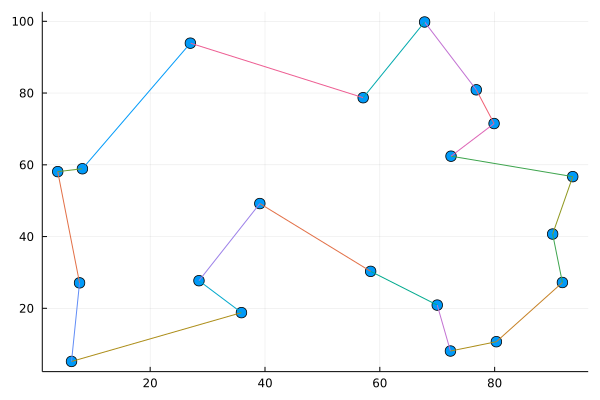

In [6]:
function display_solution(problem, route)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    plot_result = scatter(x_pos, y_pos, shape = :circle, markersize = 6)
    for i in 1:length(problem.deliveries)
        for j in 1:length(problem.deliveries)
            val = route[i, j]
            if val > 0
                del1 = problem.deliveries[i]
                del2 = problem.deliveries[j]
                plot!([del1.x, del2.x], [del1.y, del2.y], legend = false)
            end
        end
    end
    return plot_result
end;
display_solution(problem, value.(route))